### Initial Configurations and Imports

In [1]:
import json
import logging

import numpy as np
from scipy.stats import ttest_1samp, wilcoxon

from pathlib import Path
from tqdm import tqdm
 

from src.utils.data import *
from src.utils.plots import *
from src.utils.sampling import *
from src.utils.memory_management import *
from src.utils.statistics_utils import *

# Set up logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create a console handler
sh = logging.StreamHandler()
sh.setLevel(logging.INFO)
# Add the handler to the logger
logger.addHandler(sh)

from src.configs.config_parser import PathConfigParser, data_config_file, project_root

# Configs Directory
parser = PathConfigParser(str(data_config_file))
parser.load()

# Data Paths
PROCESSED_DATA_PATH = project_root / parser.get("data_paths", {}).get("processed_data")
GE_PATH = parser.get("data_paths", {}).get("brain_regions_genes_ge")
PROCESSED_DONORS_GE_PATH = PROCESSED_DATA_PATH / GE_PATH

OUTPUT_DATA = project_root / parser.get("data_paths", {}).get("output_data")

# Donors_ids
DONORS_IDS = parser.get("donors_ids")

Loading main dataframe

In [2]:
meta_donor_csv_pth = PROCESSED_DONORS_GE_PATH / Path("meta_donor.csv")
meta_donor_df = load_df_from_csv(meta_donor_csv_pth)
meta_donor_df.head(3)

meta_donor_df["gene_expression_values"]=meta_donor_df["gene_expression_values"].apply(json.loads)
logger.info(meta_donor_df["gene_expression_values"][0][0])

1.58747780630413


 Selecting Samples with sample size >= 1024

In [3]:
meta_donor_df_filtered = meta_donor_df.copy()

number_of_samples_per_br_ge = get_number_of_samples_per_br_ge(meta_donor_df_filtered)

range_with_powers_of_two = [2**i for i in range(3, 7)]

count_per_threshold= get_br_ge_count_above_sample_size(meta_donor_df_filtered, range = range_with_powers_of_two)

meta_donor_df_filtered = mask_samples_threshold(meta_donor_df_filtered, threshold=64)

meta_donor_df_filtered = meta_donor_df_filtered.reset_index(drop=True)
write_df_to_csv(meta_donor_df_filtered, PROCESSED_DONORS_GE_PATH / Path("meta_donor_filtered_64.csv"))

logger.info(f"DF Length after filtering matches number of samples expected: {count_per_threshold[len(count_per_threshold)-1]==len(meta_donor_df_filtered)}")
logger.info(count_per_threshold[len(count_per_threshold)-1])


DF Length after filtering matches number of samples expected: True
394163


In [4]:
meta_donor_df_filtered.head(3)

,brain_region,gene_id,gene_expression_values,sample_count
0,4012,6,"[1.83564765363665, 1.4949501777457102, 5.94151...",77
1,4012,53,"[3.99574025881648, 9.103833777921082, 2.051496...",77
2,4012,351,"[1.58718710332798, 6.76939517727801, 2.6839363...",66


In [5]:
import random
for index, row in meta_donor_df_filtered.iterrows():
    if row["sample_count"] > 64:
        meta_donor_df_filtered.at[index, "gene_expression_values"] = random.sample(row["gene_expression_values"], 64)
        meta_donor_df_filtered.at[index, "sample_count"] = 64


ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE
ELSE


### Calculating Gene Mean Expression Values (H0)

In [8]:
geneid_H0 = calculate_gene_mean_expression_values(meta_donor_df)
logger.info(f"Number of Total Sample Count == {geneid_H0['total_sample_count'].sum() == get_total_number_of_samples(meta_donor_df)}")

Number of Total Sample Count == True


Calculating STD for Effect Sizes

In [9]:
df_std = meta_donor_df.copy()

std_per_gene = calculate_std_gene_id_optimized(df_std)

geneid_H0["std"] = std_per_gene["std"]
write_df_to_csv(geneid_H0, OUTPUT_DATA / Path("gene_stats_64.csv"))
geneid_H0.head(3)

,gene_id,total_expression,total_sample_count,weighted_mean,std
0,2,16227.834876,3936,4.122926,2.693218
1,3,66283.660534,7872,8.420180,2.464688
2,6,41203.873837,13776,2.990990,2.067025


### Calculating P-values, Effect Size, T-statistic and Power for Different Sample Sizes

In [10]:
stats_df = pd.DataFrame(meta_donor_df_filtered).drop(columns=["gene_expression_values", "sample_count"])
for index, br_ge in tqdm(meta_donor_df_filtered.iterrows(), total=len(meta_donor_df_filtered), desc="Processing Samples"):
    effect_sizes, p_values, powers, t_obs_stats =[], [], [], []
    for sample_size in range_with_powers_of_two:
        # Getting Sample Values
        sample = br_ge["gene_expression_values"]
        
        if sample_size > len(sample):
            logger.error(f"Reproducing Error, sample size available: {len(sample)} < sample_size chosen: {sample_size}")
            raise Exception
        else:
            sample = sample[:sample_size]
        
        if len(sample) == 1:
            raise ValueError
        
        # Getting Brain region and Gene ID
        gene_id = br_ge["gene_id"]
        brain_region = br_ge["brain_region"]
        
        # Calculating Sample Stats
        sample_mean = np.mean(sample)
        sample_std = np.std(sample)
        
        
        # Getting Control Group stats for that gene
        control_group_mean = geneid_H0.loc[geneid_H0["gene_id"] == int(gene_id), "weighted_mean"].iloc[0]
        control_group_std = geneid_H0.loc[geneid_H0["gene_id"] == int(gene_id), "std"].iloc[0]
        control_group_size = geneid_H0.loc[geneid_H0["gene_id"] == int(gene_id), "total_sample_count"].iloc[0]


        # (1) Calculating Effect Size.
        effect_size = calculate_cohen_d(sample_mean=sample_mean, control_group_mean=control_group_mean,
                        sample_std=sample_std, control_group_std=control_group_std,
                        sample_length=sample_size, control_group_length=control_group_size)

        # (2) Calculating Power
        power = calculate_test_power(effect_size, sample_mean, control_group_mean, sample_std, sample_size)
        
        # (3) Calculating T Statistic and P-Value
        t_static, p_value  = wilcoxon(np.array(sample) - control_group_mean, alternative='greater')

        
        stats_df.loc[index, f"effect_size_{sample_size}"] = effect_size
        stats_df.loc[index, f"p-value_{sample_size}"] = p_value
        stats_df.loc[index, f"power_{sample_size}"] = power
        stats_df.loc[index, f"t_stat_{sample_size}"] = t_static

    
    
write_df_to_csv(stats_df, OUTPUT_DATA / Path(f"df_stats_64.csv"))



Processing Samples: 100%|██████████| 394163/394163 [47:43<00:00, 137.65it/s] 


In [11]:
stats_df.head(3)

,brain_region,gene_id,effect_size_8,p-value_8,power_8,t_stat_8,effect_size_16,p-value_16,power_16,t_stat_16,effect_size_32,p-value_32,power_32,t_stat_32,effect_size_64,p-value_64,power_64,t_stat_64
0,4012,6,0.127825,0.527344,0.093940,18.0,-0.043628,0.683914,0.035016,59.0,-0.177761,0.933181,0.004283,184.0,0.004333,0.730805,0.053638,948.0
1,4012,53,-0.571795,0.902344,0.000895,9.0,-0.395842,0.928070,0.000788,40.0,-0.208418,0.888011,0.002566,199.0,0.029961,0.438879,0.079605,1063.0
2,4012,351,-0.281899,0.769531,0.008861,13.0,0.034717,0.530060,0.065252,67.0,-0.104694,0.731969,0.013062,231.0,-0.011082,0.595126,0.041587,1004.0


Filter out Brain Regions with few Occurrences to plot

In [92]:
# Group by brain_region and count occurrences
group_counts = stats_df["brain_region"].value_counts()

# Filter out brain regions that have less than 8 occurrences
valid_regions = group_counts[group_counts >= 8].index

# Filter original DataFrame
filtered_df = stats_df[stats_df["brain_region"].isin(valid_regions)].drop(columns=['gene_id'])
filtered_df = filtered_df[filtered_df['brain_region'] != 4288]
filtered_df = filtered_df.groupby("brain_region")

# Calculating Mean and Variances
filtered_df_mean = filtered_df.mean()
filtered_df_var = filtered_df.var()


### Effect Size VS Sample Size Plots

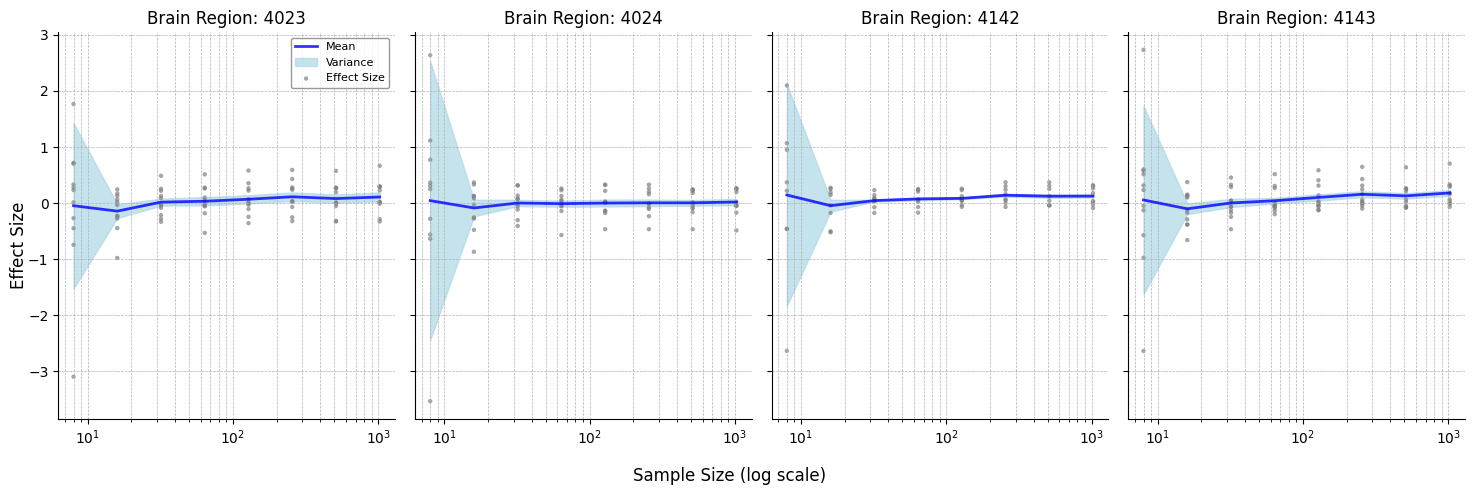

In [102]:
# Define colors for means, variances, and effect sizes
mean_color = 'blue'  # Color for mean lines
variance_color = 'lightblue'  # Color for variance shading
effect_size_color = 'gray'  # Color for individual effect size points

# Define columns for effect sizes
columns = [f"effect_size_{sample_size}" for sample_size in range_with_powers_of_two]

# Extract means and variances
effect_size_df_mean = filtered_df_mean[columns]
effect_size_df_var = filtered_df_var[columns]

# Transpose for plotting
transpose_effect_size_mean = effect_size_df_mean.T.reset_index(drop=True)
transpose_effect_size_var = effect_size_df_var.T.reset_index(drop=True)

# Initialize figure with subplots
num_regions = len(transpose_effect_size_mean.columns)
fig, axes = plt.subplots(nrows=1, ncols=num_regions, figsize=(15, 5), sharey=True)

# Plot each region in a separate subplot
for idx, (ax, column) in enumerate(zip(axes, transpose_effect_size_mean)):

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Plot mean as solid line
    ax.plot(range_with_powers_of_two, transpose_effect_size_mean[column].values, 
            color=mean_color, linewidth=2, alpha=0.8, label="Mean")
    
    # Plot variance as shaded region
    ax.fill_between(range_with_powers_of_two, 
                    transpose_effect_size_mean[column].values - transpose_effect_size_var[column].values, 
                    transpose_effect_size_mean[column].values + transpose_effect_size_var[column].values, 
                    color=variance_color, alpha=0.7, label="Variance")
    
    # Plot individual effect size values
    # Filter rows where 'Value' is greater than 30 in each group
    region_samples = filtered_df.filter(lambda x: (x['brain_region']== column).any())
    for sample_idx, sample_size in enumerate(range_with_powers_of_two):
        sample_values = region_samples[f"effect_size_{sample_size}"]
        ax.scatter([sample_size] * len(sample_values), sample_values, 
                   color=effect_size_color, alpha=0.7, s=10, edgecolor='none', label="Effect Size" if sample_idx == 0 else "")
    
    # Use a logarithmic x-axis for better scaling
    ax.set_xscale("log")    
    ax.set_title(f"Brain Region: {column}")
    
    # Add grid
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    
    # Add legend (only for the first subplot to avoid repetition)
    if idx == 0:
        ax.legend(loc="upper right", fontsize=8, frameon=True, facecolor='white', edgecolor='gray')


# Add a single centered x-axis label below all subplots
fig.supxlabel("Sample Size (log scale)", fontsize=12, y=0.02)

# Add a single y-axis label
fig.supylabel("Effect Size", fontsize=12, x=0.02)

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot to a file
output_filename = PLOTS_PTH / Path("effect_size_vs_sample_size_1024.png")  # You can change the file name and format (e.g., .pdf, .svg)
plt.savefig(output_filename, dpi=300, bbox_inches='tight')

# Show plot
plt.show()